# MBG/NBD Model

In this notebook we show how to fit a MBG/NBD model in PyMC-Marketing. We compare the results with the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package (no longer maintained). The model is presented in the paper: Batislam E. P., Denizel M., Filiztekin A. (2007) [Empirical validation and comparison of models for customer base analysis](https://www.sciencedirect.com/science/article/abs/pii/S0167811607000171)

## Prepare Notebook

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from fastprogress.fastprogress import progress_bar
from lifetimes import ModifiedBetaGeoFitter

from pymc_marketing import clv

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

## Read Data

We use the `CDNOW` dataset (see lifetimes [quick-start](https://lifetimes.readthedocs.io/en/latest/Quickstart.html)).

In [32]:
data_path = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/clv_quickstart.csv"

df = pd.read_csv(data_path)

df.head()

,frequency,recency,T,monetary_value
0,2,30.43,38.86,22.35
1,1,1.71,38.86,11.77
2,0,0.00,38.86,0.00
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00


Recall from the `lifetimes` documentation the following definitions:

> - `frequency` represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
> - `T` represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
> - `recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

```{tip}
We rename the index column to `customer_id` as this is required by the model
```

In [33]:
data = (
    df.reset_index()
    .rename(columns={"index": "customer_id"})
    .drop(columns="monetary_value")
)

## Model Specification

The MBG/NBD model is a probabilistic model that describes the buying behavior of a customer in the non-contractual setting. It is based on the following assumptions for each customer:

### Dropout after first purchase

Contrasting with the BG/NBD model, in the MBG/NBD a customer may drop out at time zero with probability p. 
This leads to the following individual level likelihood function: 

$$ L(\lambda, p | X=x, T) = (1 - p)^{x+1} \lambda^x \exp(\lambda T) + p(1-p)^x \lambda^x \exp(-\lambda t_x)$$

Compare the previous expresion with the regular BG/NBD likelihood:

$$ L(\lambda, p | X=x, T) = (1 - p)^{x} \lambda^x \exp(\lambda T) + \delta_{x>0} p(1-p)^{x-1} \lambda^x \exp(-\lambda t_x)$$


## Model Fitting

Estimating such parameters is very easy in PyMC-Marketing. We instantiate the model in a similar way:

In [34]:
model = clv.ModifiedBetaGeoModel(data=data)

And *build* the model to see the model configuration:

In [35]:
model.build_model()
model

MBG/NBD
        alpha ~ HalfFlat()
            r ~ HalfFlat()
  phi_dropout ~ Uniform(0, 1)
kappa_dropout ~ Pareto(1, 1)
            a ~ Deterministic(f(kappa_dropout, phi_dropout))
            b ~ Deterministic(f(kappa_dropout, phi_dropout))
   likelihood ~ Potential(f(r, alpha, kappa_dropout, phi_dropout))

Notice the additional `phi_dropout` and `kappa_dropout` priors. These were added to the default configuration to improve performance, but can be omitted when specifying a custom `model_config` with `a_prior` and `b_prior`.

The specified model structure can also be visualized:

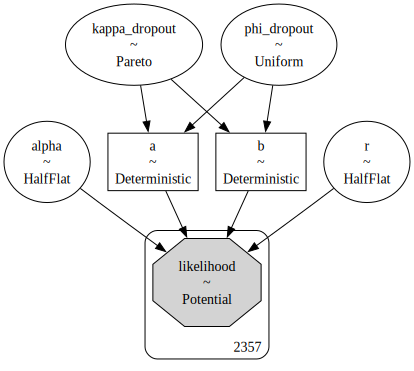

In [36]:
model.graphviz()

We can now fit the model. The default sampler in PyMC-Marketing is the No-U-Turn Sampler (NUTS). We use the default $4$ chains and $1000$ draws per chain.

```{note}
It is not necessary to build the model before fitting it. We can fit the model directly.
```

In [37]:
sample_kwargs = {
    "draws": 2_000,
    "chains": 4,
    "target_accept": 0.9,
    "random_seed": 42,
}

idata_mcmc = model.fit(**sample_kwargs)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, r, phi_dropout, kappa_dropout]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


In [38]:
idata_mcmc

Inference data with groups:
	> posterior
	> sample_stats
	> fit_data

We can look into the summary table:

In [39]:
model.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,6.499,0.726,5.204,7.883,0.016,0.011,2156.0,3096.0,1.0
r,0.565,0.089,0.413,0.737,0.002,0.002,1694.0,2566.0,1.0
phi_dropout,0.369,0.042,0.292,0.447,0.001,0.001,1728.0,2444.0,1.0
kappa_dropout,2.429,0.687,1.406,3.604,0.016,0.012,1819.0,2521.0,1.0
a,0.873,0.155,0.624,1.166,0.003,0.002,2566.0,3047.0,1.0
b,1.556,0.546,0.766,2.486,0.013,0.010,1717.0,2336.0,1.0


We see that the `r_hat` values are close to $1$, which indicates convergence. 

We can also plot posterior distributions of the parameters and the rank plots:

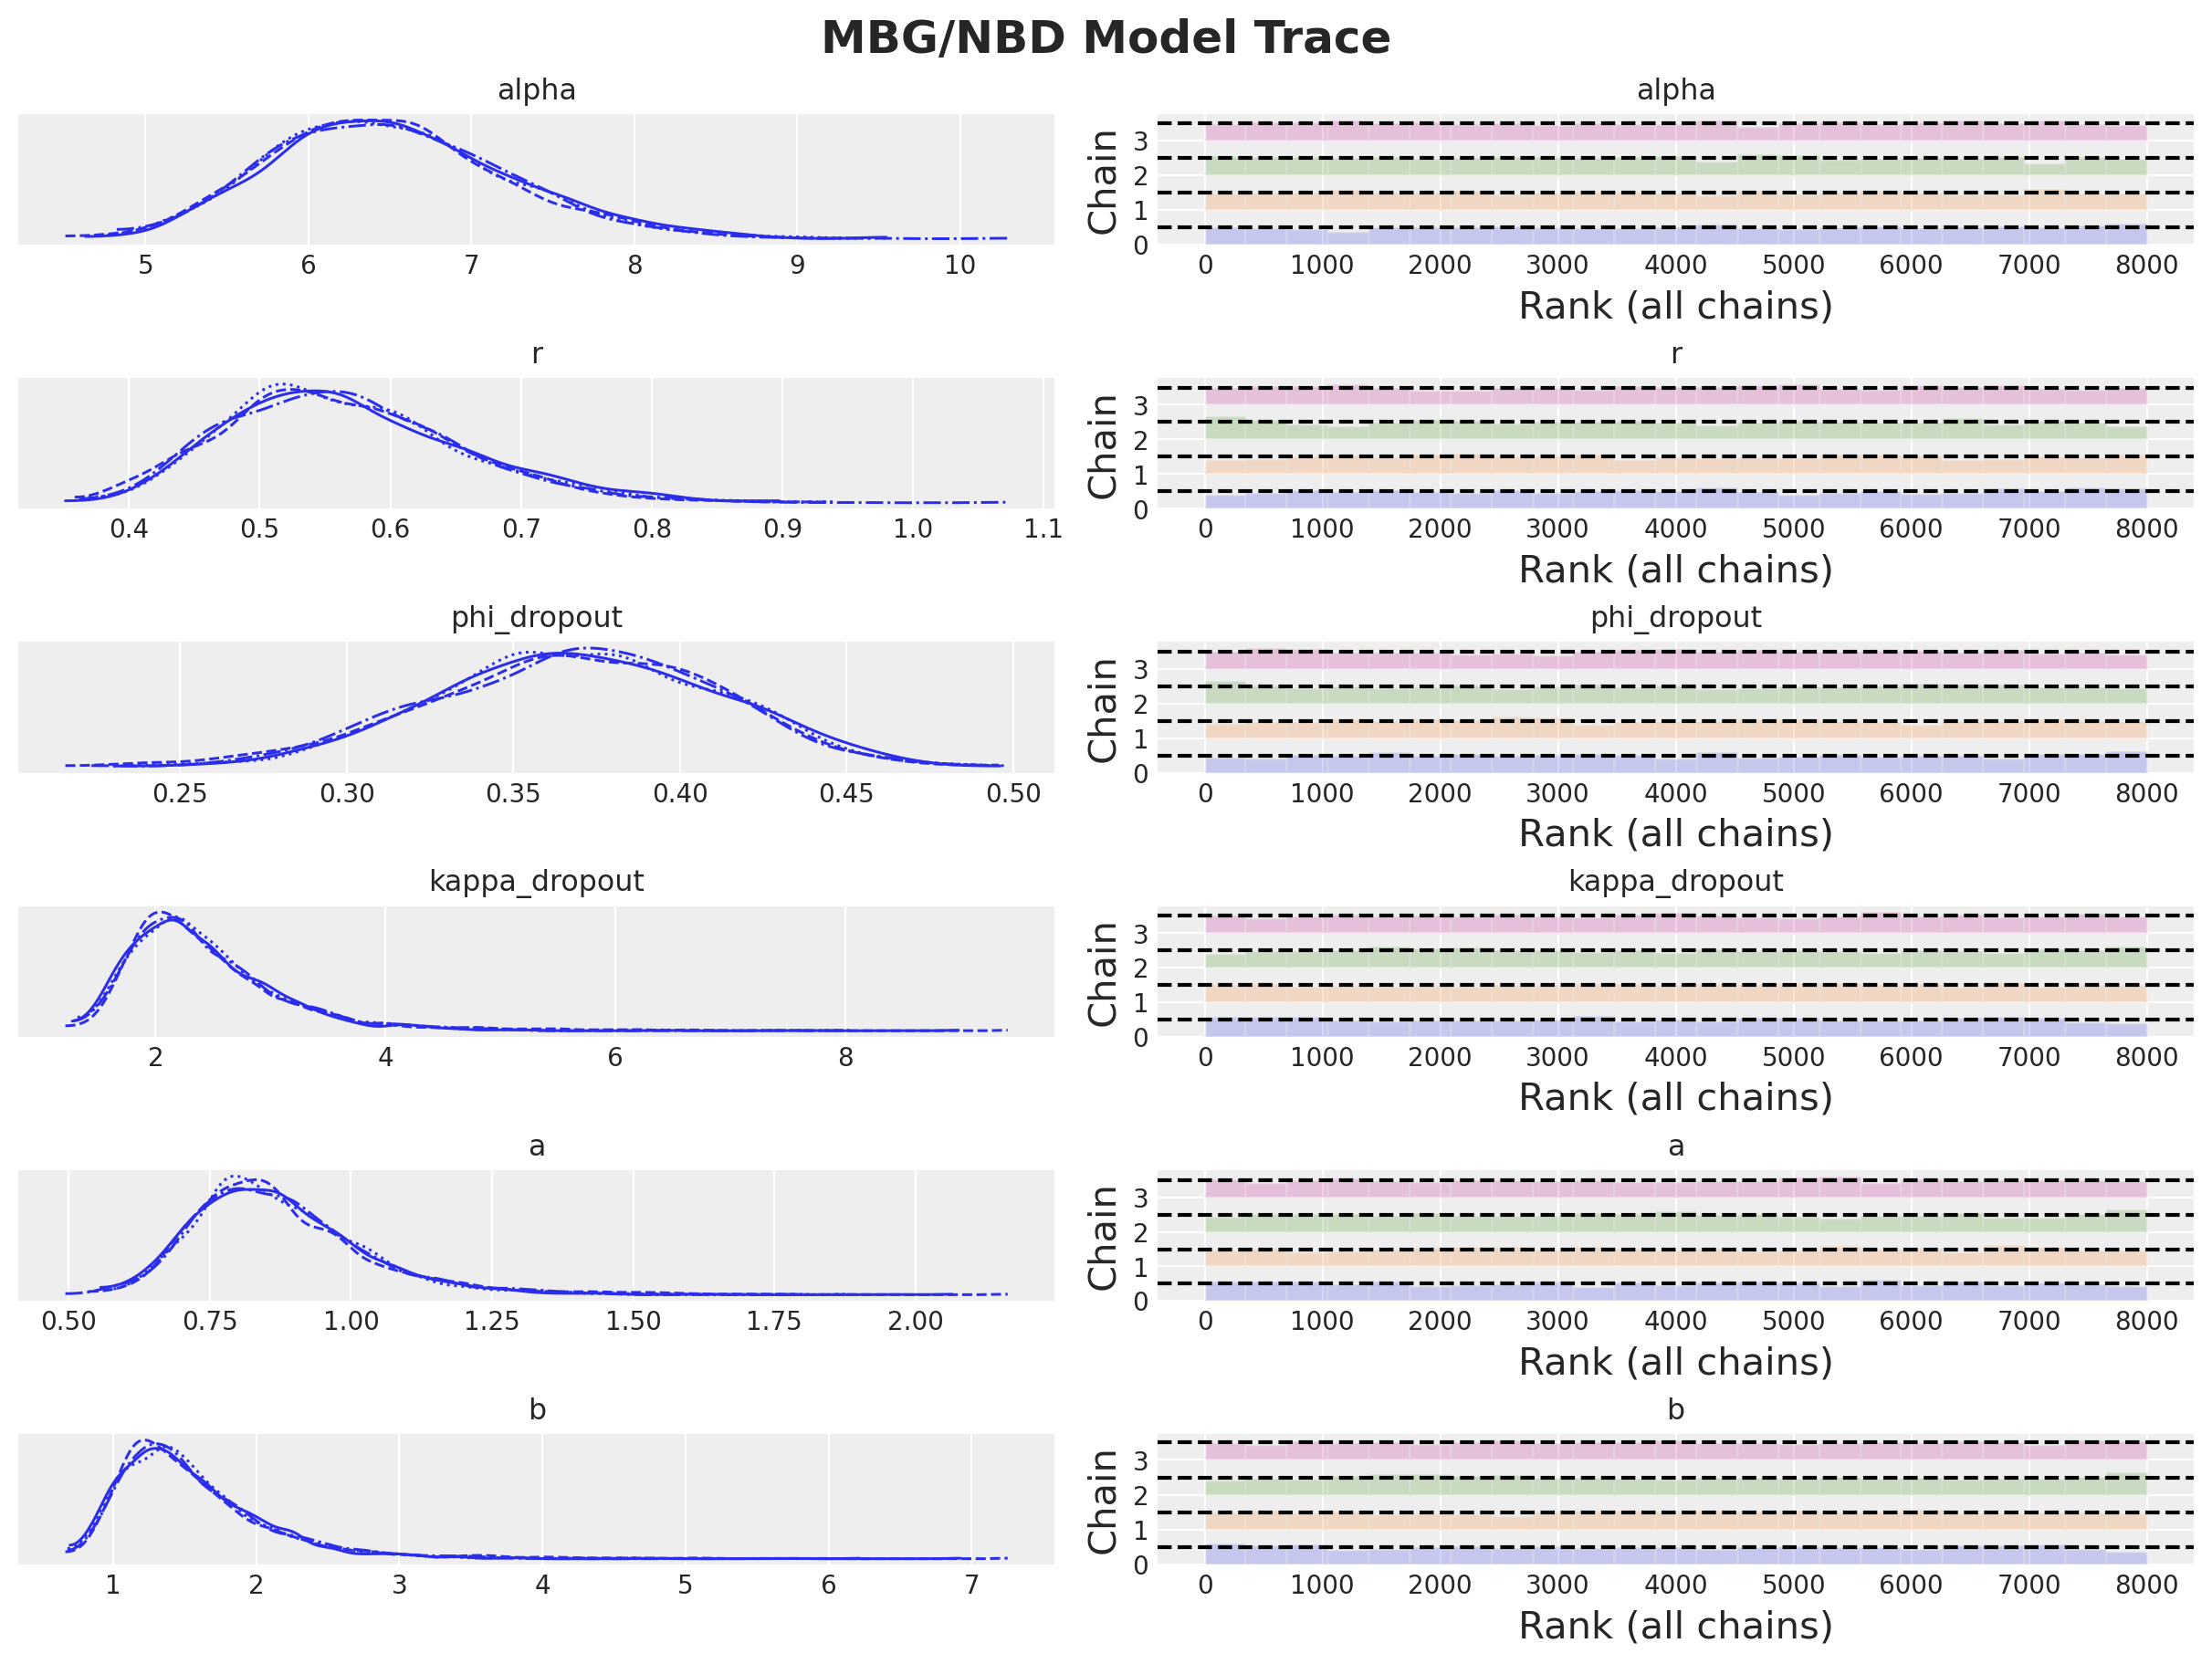

In [40]:
axes = az.plot_trace(
    data=model.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("MBG/NBD Model Trace", fontsize=18, fontweight="bold");

### Using MAP fit

CLV models such as `BetaGeoModel`, can provide the maximum a posteriori estimates using a numerical optimizer (`L-BFGS-B` from `scipy.optimize`) under the hood.

In [41]:
model_map = clv.ModifiedBetaGeoModel(data=data)
idata_map = model_map.fit(fit_method="map")

Output()

In [42]:
idata_map

Inference data with groups:
	> posterior
	> fit_data

This time we get point estimates for the parameters.

In [43]:
map_summary = model_map.fit_summary()

map_summary

alpha            6.404
r                0.559
phi_dropout      0.375
kappa_dropout    2.206
a                0.826
b                1.380
Name: value, dtype: float64

## Comparing with the `lifetimes` package

For the sake of comparison, let's fit the model using the `lifetimes` package.

In [44]:
mbgf = ModifiedBetaGeoFitter()
mbgf.fit(
    frequency=data["frequency"].values,
    recency=data["recency"].values,
    T=data["T"].values,
)

mbgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.524838,0.083264,0.361640,0.688035
alpha,6.182988,0.695597,4.819618,7.546359
a,0.891356,0.154785,0.587977,1.194736
b,1.614000,0.537472,0.560554,2.667446


The `r` and `alpha` purchase rate parameters are quite similar for all three models, but the `a` and `b` dropout parameters are better approximated with the default parameters when fitted with MCMC.

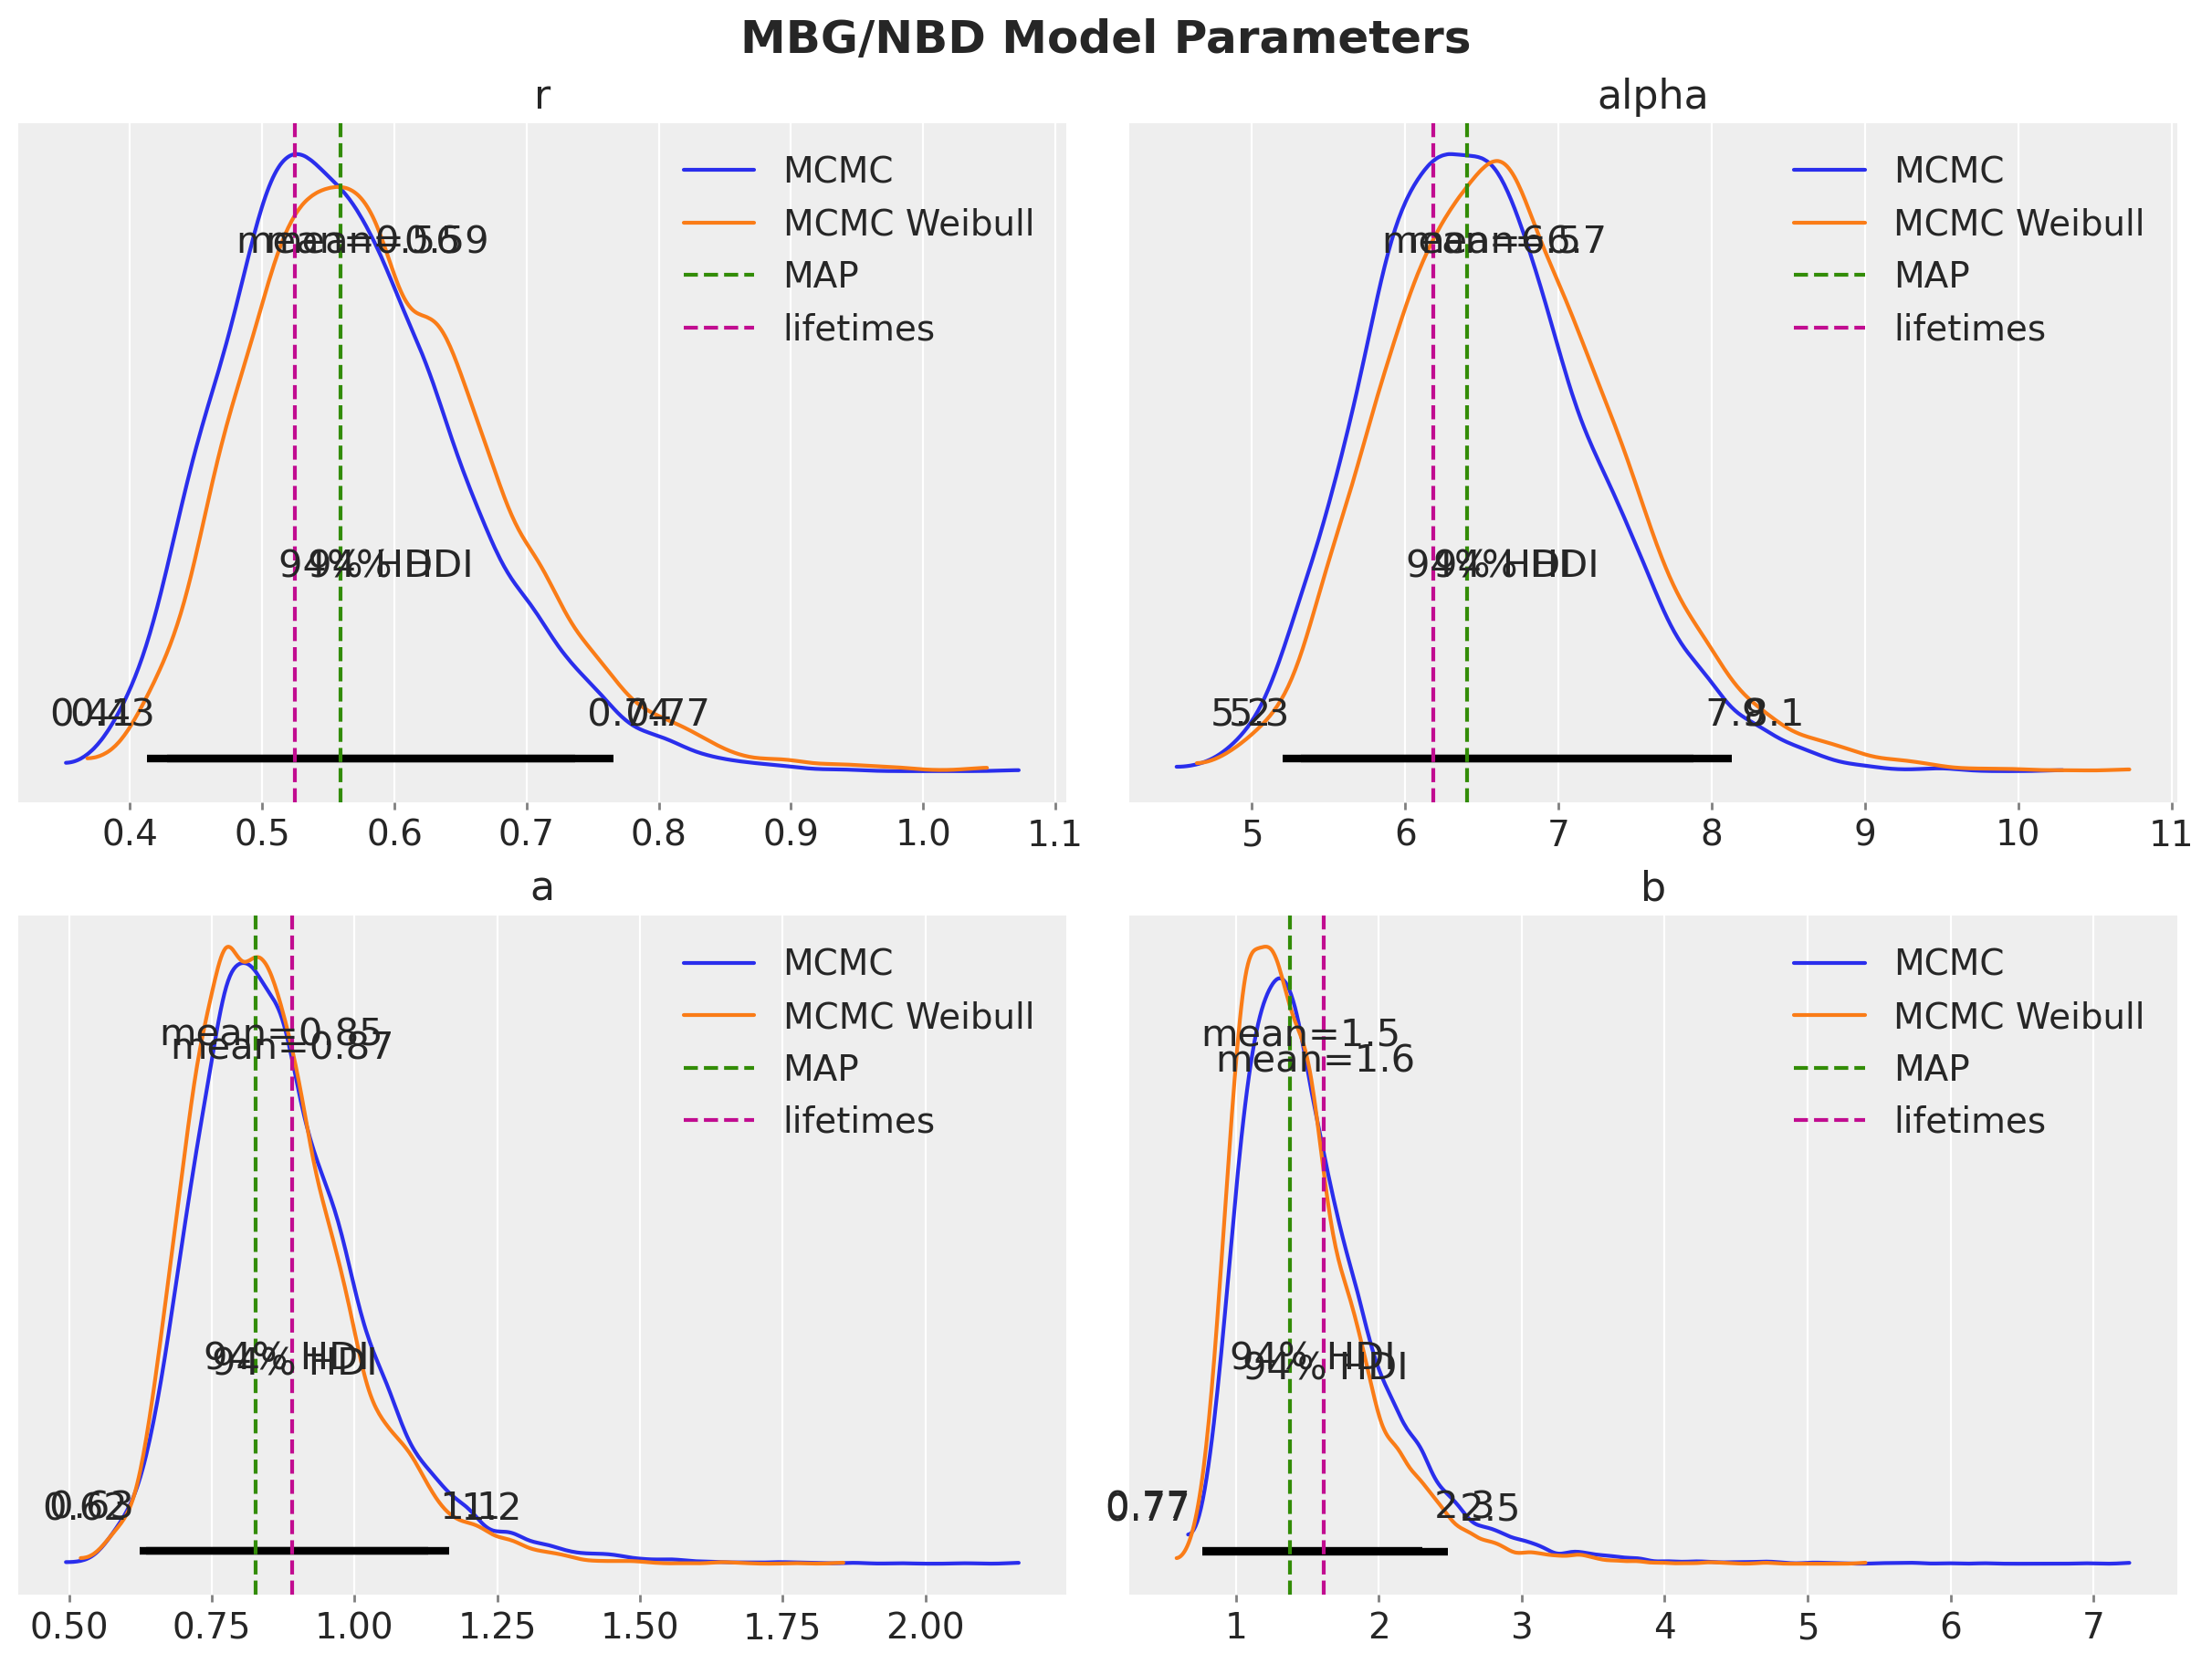

In [77]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 9), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "a", "b"]):
    ax = axes[i]
    az.plot_posterior(
        model.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="MCMC",
    )
    ax.axvline(x=map_summary[var_name], color="C1", linestyle="--", label="MAP")
    ax.axvline(
        x=mbgf.summary["coef"][var_name], color="C2", linestyle="--", label="lifetimes"
    )
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle("MBG/NBD Model Parameters", fontsize=18, fontweight="bold");

## Some Applications

Now that you have fitted the model, we can use it to make predictions. For example, we can predict the expected probability of a customer being alive as a function of time (steps). Here is a snippet of code to do that:

### Expected Number of Purchases

Let us take a sample of users:

In [46]:
example_customer_ids = [1, 6, 10, 18, 45, 1412]

data_small = data.query("customer_id.isin(@example_customer_ids)")

data_small.head(6)

,customer_id,frequency,recency,T
1,1,1,1.71,38.86
6,6,1,5.00,38.86
10,10,5,24.43,38.86
18,18,3,28.29,38.71
45,45,12,34.43,38.57
1412,1412,14,30.29,31.57


Observe that the last two customers are *frequent buyers* as compared to the others.

In [47]:
steps = 90

expected_num_purchases_steps = xr.concat(
    objs=[
        model.expected_purchases(
            data=data_small,
            future_t=t,
        )
        for t in progress_bar(range(steps))
    ],
    dim="t",
).transpose(..., "t")

We can plot the expected number of purchases for the next $90$ periods:

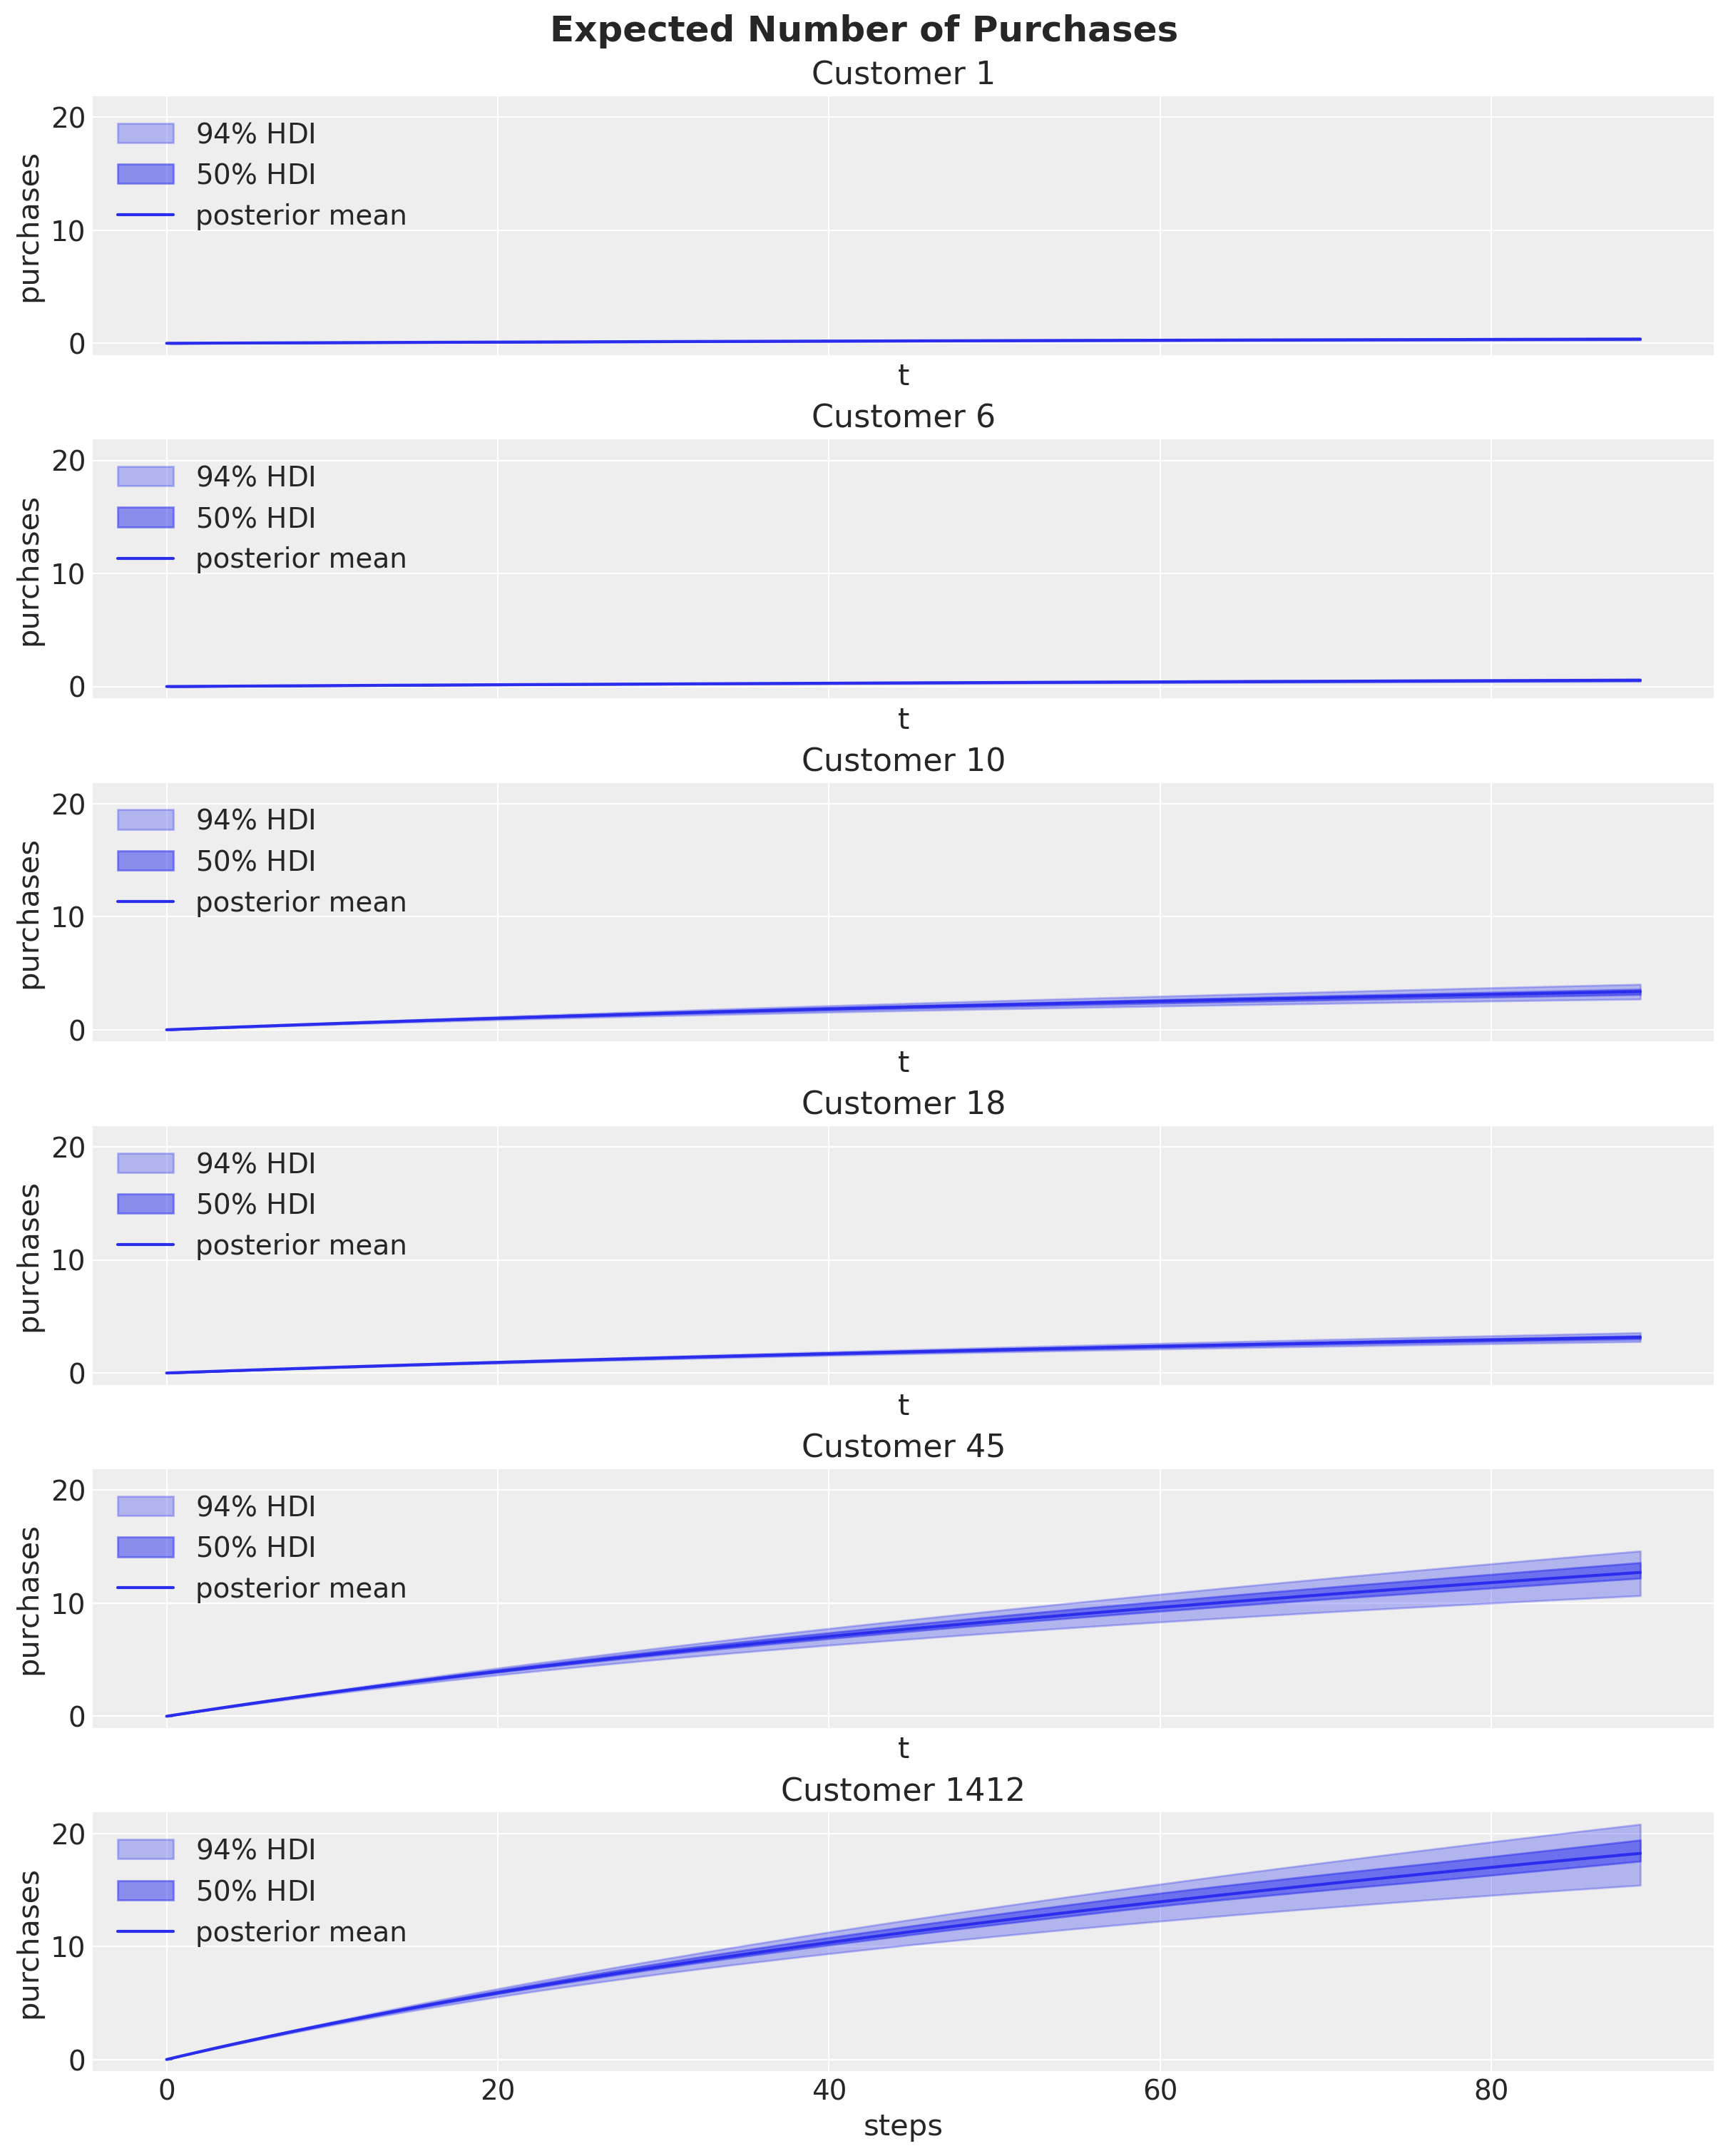

In [48]:
fig, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_num_purchases_steps = expected_num_purchases_steps.sel(
        customer_id=customer_id
    )
    az.plot_hdi(
        range(steps),
        customer_expected_num_purchases_steps,
        hdi_prob=0.94,
        color="C0",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(steps),
        customer_expected_num_purchases_steps,
        hdi_prob=0.5,
        color="C0",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(steps),
        customer_expected_num_purchases_steps.mean(dim=("chain", "draw")),
        color="C0",
        label="posterior mean",
    )
    ax.legend(loc="upper left")
    ax.set(title=f"Customer {customer_id}", xlabel="t", ylabel="purchases")

axes[-1].set(xlabel="steps")
plt.gcf().suptitle("Expected Number of Purchases", fontsize=18, fontweight="bold");

Note that the *frequent buyers* are expected to make more purchases in the future.

### Probability of a Customer Being Alive

We now look into the probability of a customer being alive for the next $90$ periods:

In [49]:
steps = 90

future_alive_all = []

for t in progress_bar(range(steps)):
    future_data = data_small.copy()
    future_data["T"] = future_data["T"] + t
    future_alive = model.expected_probability_alive(data=future_data)
    future_alive_all.append(future_alive)

expected_probability_alive_steps = xr.concat(
    objs=future_alive_all,
    dim="t",
).transpose(..., "t")

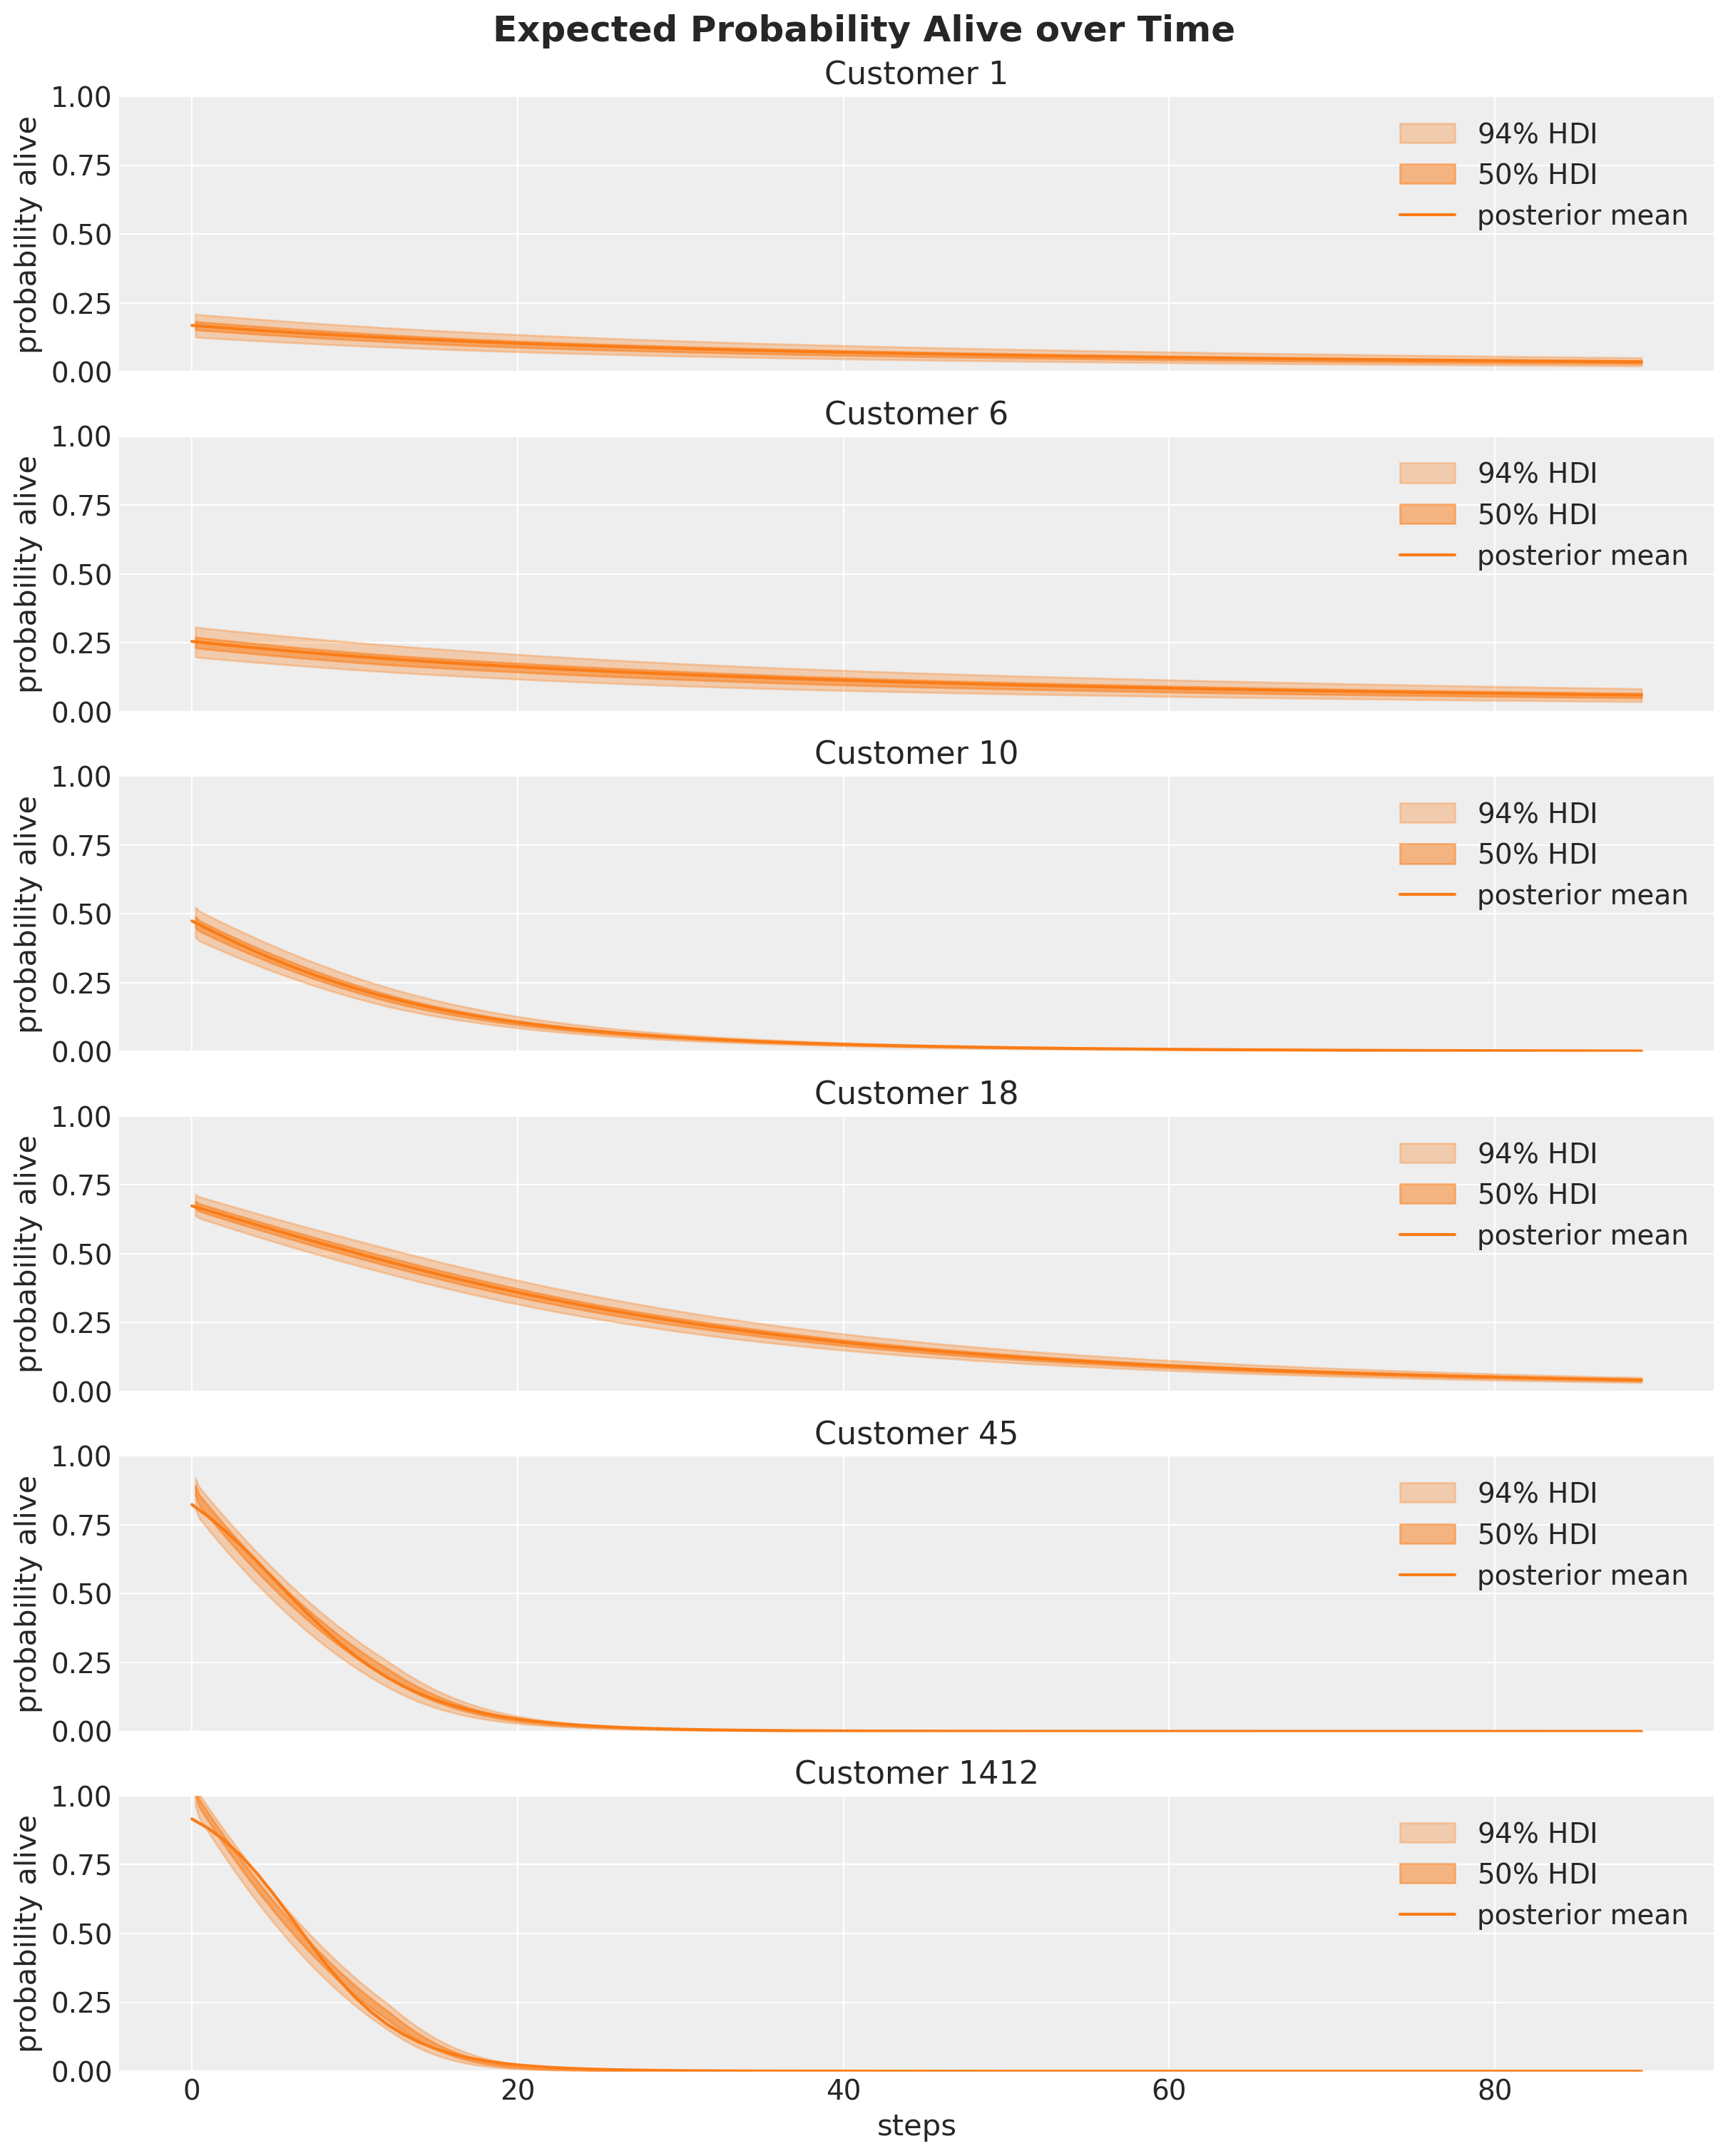

In [50]:
fig, axes = plt.subplots(
    nrows=len(example_customer_ids),
    ncols=1,
    figsize=(12, 15),
    sharex=True,
    sharey=True,
    layout="constrained",
)

axes = axes.flatten()

for i, customer_id in enumerate(example_customer_ids):
    ax = axes[i]
    customer_expected_probability_alive_steps = expected_probability_alive_steps.sel(
        customer_id=customer_id
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_alive_steps,
        hdi_prob=0.94,
        color="C1",
        fill_kwargs={"alpha": 0.3, "label": "$94 \\%$ HDI"},
        ax=ax,
    )
    az.plot_hdi(
        range(steps),
        customer_expected_probability_alive_steps,
        hdi_prob=0.5,
        color="C1",
        fill_kwargs={"alpha": 0.5, "label": "$50 \\%$ HDI"},
        ax=ax,
    )
    ax.plot(
        range(steps),
        customer_expected_probability_alive_steps.mean(dim=("chain", "draw")),
        color="C1",
        label="posterior mean",
    )
    ax.legend(loc="upper right")
    ax.set(title=f"Customer {customer_id}", ylabel="probability alive", ylim=(0, 1))

axes[-1].set(xlabel="steps")
plt.gcf().suptitle(
    "Expected Probability Alive over Time", fontsize=18, fontweight="bold"
);

```{tip}
Here are some general remarks:
- **These plots assume no future purchases.**
- The decay probability is not the same as it depends in the purchase history of the customer. 
- The probability of being alive is always decreasing as we are assuming there is no change in the other parameters. 
- These probabilities are always non-negative, as expected.
```

```{warning}
For the frequent buyers, the probability of being alive drops very fast as we are assuming no future purchases. It is very important to keep this in mind when interpreting the results.
```

In [53]:
%reload_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Fri Dec 20 2024

Python implementation: CPython
Python version       : 3.10.16
IPython version      : 8.30.0

pymc    : 5.19.1
pytensor: 2.26.4

fastprogress  : 1.0.3
pymc_marketing: 0.10.0
matplotlib    : 3.9.3
pandas        : 2.2.3
arviz         : 0.20.0
lifetimes     : 0.11.3
xarray        : 2024.11.0

Watermark: 2.5.0

